In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
data = pd.read_csv('eco_rating.csv')
data.head()

,user_id,item_id,ratings
0,1,28,2
1,1,86,4
2,1,94,4
3,1,146,3
4,2,17,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  849 non-null    int64
 1   item_id  849 non-null    int64
 2   ratings  849 non-null    int64
dtypes: int64(3)
memory usage: 20.0 KB


In [ ]:
# Mengetahui total unique dari kolom user_id & place_id
len(data.user_id.unique())
len(data.item_id.unique())

182

In [ ]:
# Mengetahui keberadaan data yang hilang pada dataframe

data.isnull().sum()

user_id    0
item_id    0
ratings    0
dtype: int64

In [ ]:
# Menghapus data duplikat di kolom place_id

data_prep = data.drop_duplicates('item_id')

In [ ]:
data_prep.describe()

,user_id,item_id,ratings
count,182.000000,182.000000,182.000000
mean,33.912088,92.500000,3.521978
std,29.649201,52.683014,0.896316
min,1.000000,2.000000,2.000000
25%,10.250000,47.250000,3.000000
50%,25.000000,92.500000,4.000000
75%,52.500000,137.750000,4.000000
max,154.000000,183.000000,5.000000


In [ ]:
# Membuat list dari nilai unique pada user_id & item_id

user_ids = data.user_id.unique().tolist()
place_ids = data.item_id.unique().tolist()

In [ ]:
# Konversi data user_id & item_id ke label encoder

user_to_user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {x: i for x, i in enumerate(place_ids)}

In [ ]:
data['user'] = data.user_id.map(user_to_user_encoded)
data['place'] = data.item_id.map(place_to_place_encoded)

data.head()

,user_id,item_id,ratings,user,place
0,1,28,2,0,0
1,1,86,4,0,1
2,1,94,4,0,2
3,1,146,3,0,3
4,2,17,2,1,4


In [ ]:
data['user_rating'] = data['ratings'].values.astype(np.float32)
data

,user_id,item_id,ratings,user,place,user_rating
0,1,28,2,0,0,2.0
1,1,86,4,0,1,4.0
2,1,94,4,0,2,4.0
3,1,146,3,0,3,3.0
4,2,17,2,1,4,2.0
...,...,...,...,...,...,...
844,156,144,4,155,88,4.0
845,156,15,5,155,46,5.0
846,156,29,4,155,77,4.0
847,156,52,4,155,155,4.0


In [ ]:
df = data.sample(frac=1,random_state=42)
df.head()

,user_id,item_id,ratings,user,place,user_rating
512,93,39,4,92,129,4.0
357,66,79,3,65,151,3.0
110,22,10,4,21,86,4.0
684,125,76,3,124,136,3.0
39,7,104,4,6,23,4.0


In [ ]:
x = df[['user','place']].values

y = df['user_rating'].apply(lambda x:(x-min(df.user_rating))/(max(df.user_rating-min(df.user_rating)))).values

train_indices = int(0.8 * df.shape[0])

x_train,x_val,y_train,y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x,y)

[[ 92 129]
 [ 65 151]
 [ 21  86]
 ...
 [ 49  45]
 [ 78 108]
 [ 19  80]] [0.66666667 0.33333333 0.66666667 0.33333333 0.66666667 0.33333333
 0.66666667 0.33333333 0.         0.66666667 0.33333333 0.33333333
 0.         0.66666667 0.33333333 0.66666667 0.         0.33333333
 0.33333333 0.66666667 1.         0.33333333 0.66666667 0.33333333
 0.33333333 0.66666667 0.33333333 1.         0.         0.33333333
 0.         0.33333333 0.33333333 0.33333333 1.         0.66666667
 0.66666667 0.33333333 0.33333333 0.         0.66666667 0.66666667
 0.33333333 0.33333333 0.66666667 0.         0.         0.33333333
 0.33333333 0.         0.66666667 0.         0.66666667 0.66666667
 0.66666667 0.33333333 0.66666667 0.33333333 0.66666667 0.66666667
 0.33333333 0.66666667 0.33333333 0.66666667 0.66666667 0.33333333
 1.         1.         0.33333333 1.         0.         0.66666667
 0.66666667 0.         0.66666667 0.         0.66666667 0.33333333
 0.66666667 0.33333333 1.         0.66666667 0.33333333 0

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1)
    self.place_embedding = tf.keras.layers.Embedding(
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.place_bias = tf.keras.layers.Embedding(num_place, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(len(user_to_user_encoded), len(place_to_place_encoded), 100)

# model compile
model.compile(
    loss = 'mean_squared_error',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (x_val, y_val),
)

Epoch 1/100
43/43 [==============================] - 1s 9ms/step - loss: 0.1121 - mean_absolute_error: 0.2801 - root_mean_squared_error: 0.3342 - val_loss: 0.1174 - val_mean_absolute_error: 0.2805 - val_root_mean_squared_error: 0.3421
Epoch 2/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1168 - mean_absolute_error: 0.2822 - root_mean_squared_error: 0.3411 - val_loss: 0.1175 - val_mean_absolute_error: 0.2810 - val_root_mean_squared_error: 0.3422
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1065 - mean_absolute_error: 0.2666 - root_mean_squared_error: 0.3257 - val_loss: 0.1185 - val_mean_absolute_error: 0.2834 - val_root_mean_squared_error: 0.3437
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1044 - mean_absolute_error: 0.2681 - root_mean_squared_error: 0.3225 - val_loss: 0.1198 - val_mean_absolute_error: 0.2852 - val_root_mean_squared_error: 0.3455
Epoch 5/100
43/43 [==============================] - 0s 3ms/

In [ ]:
result_metrics = model.evaluate(x_val, y_val)
print(f'MAE: {result_metrics[1]}\n RMSE: {result_metrics[2]}')

6/6 [==============================] - 0s 4ms/step - loss: 0.1382 - mean_absolute_error: 0.3063 - root_mean_squared_error: 0.3714
MAE: 0.30630621314048767
 RMSE: 0.37137171626091003


#Wisata di Kota Batu Malang

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.25.2
pandas version :  1.5.3
seaborn version :  0.13.1


In [ ]:
df = pd.read_excel("Dataset_227(10F).xlsx")
df.head()

,jenis_kelamin,umur,pekerjaan,hobi,tujuan_berwisata,status_perkawinan,daerah_asal,teman_perjalanan,pendidikan_terakhir,repetition,...,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12,Y13,Y14
0,Laki-Laki,12-25 tahun,Pelajar/Mahasiswa,Olahraga,Rekreasi/Liburan,Belum Menikah,Luar Kota Batu,Pasangan,SMA/SMK,Pernah,...,1,0,0,0,0,0,0,0,0,0
1,Perempuan,12-25 tahun,Wiraswasta,Traveling,Rekreasi/Liburan,Belum Menikah,Luar Kota Batu,Teman,SMA/SMK,Belum Pernah,...,1,0,0,1,0,0,0,0,0,0
2,Perempuan,12-25 tahun,Pelajar/Mahasiswa,Traveling,Rekreasi/Liburan,Belum Menikah,Luar Kota Batu,Keluarga,SMA/SMK,Pernah,...,1,1,0,1,0,0,0,1,0,0
3,Perempuan,12-25 tahun,Pelajar/Mahasiswa,Traveling,Rekreasi/Liburan,Belum Menikah,Luar Kota Batu,Teman,SMA/SMK,Belum Pernah,...,1,1,0,1,0,1,0,0,0,0
4,Laki-Laki,12-25 tahun,Pelajar/Mahasiswa,Olahraga,Rekreasi/Liburan,Belum Menikah,Luar Kota Batu,Teman,SMA/SMK,Pernah,...,0,1,1,1,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   jenis_kelamin        227 non-null    object
 1   umur                 227 non-null    object
 2   pekerjaan            227 non-null    object
 3   hobi                 227 non-null    object
 4   tujuan_berwisata     227 non-null    object
 5   status_perkawinan    227 non-null    object
 6   daerah_asal          227 non-null    object
 7   teman_perjalanan     227 non-null    object
 8   pendidikan_terakhir  227 non-null    object
 9   repetition           227 non-null    object
 10  Y1                   227 non-null    int64 
 11  Y2                   227 non-null    int64 
 12  Y3                   227 non-null    int64 
 13  Y4                   227 non-null    int64 
 14  Y5                   227 non-null    int64 
 15  Y6                   227 non-null    int64 
 16  Y7      

Dari info diatas, tidak ada keberadaan missing value / NaN.

In [ ]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(include=['int64']).columns)

Memisahkan kolom yang bertipe objek (category) dengan yang numeric (eg. float,int, dll)

In [ ]:
df[cats].describe()

,jenis_kelamin,umur,pekerjaan,hobi,tujuan_berwisata,status_perkawinan,daerah_asal,teman_perjalanan,pendidikan_terakhir,repetition
count,227,227,227,227,227,227,227,227,227,227
unique,2,4,4,5,4,2,2,5,4,2
top,Perempuan,12-25 tahun,Pelajar/Mahasiswa,Traveling,Rekreasi/Liburan,Belum Menikah,Kota Batu,Keluarga,SMA/SMK,Pernah
freq,144,140,91,113,215,142,115,115,152,137


In [ ]:
df[nums].describe()

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12,Y13,Y14
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.00000
mean,0.612335,0.638767,0.568282,0.502203,0.511013,0.374449,0.286344,0.541850,0.140969,0.268722,0.193833,0.171806,0.105727,0.08370
std,0.488294,0.481420,0.496410,0.501100,0.500983,0.485050,0.453051,0.499347,0.348759,0.444275,0.396173,0.378046,0.308167,0.27755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


<Axes: >

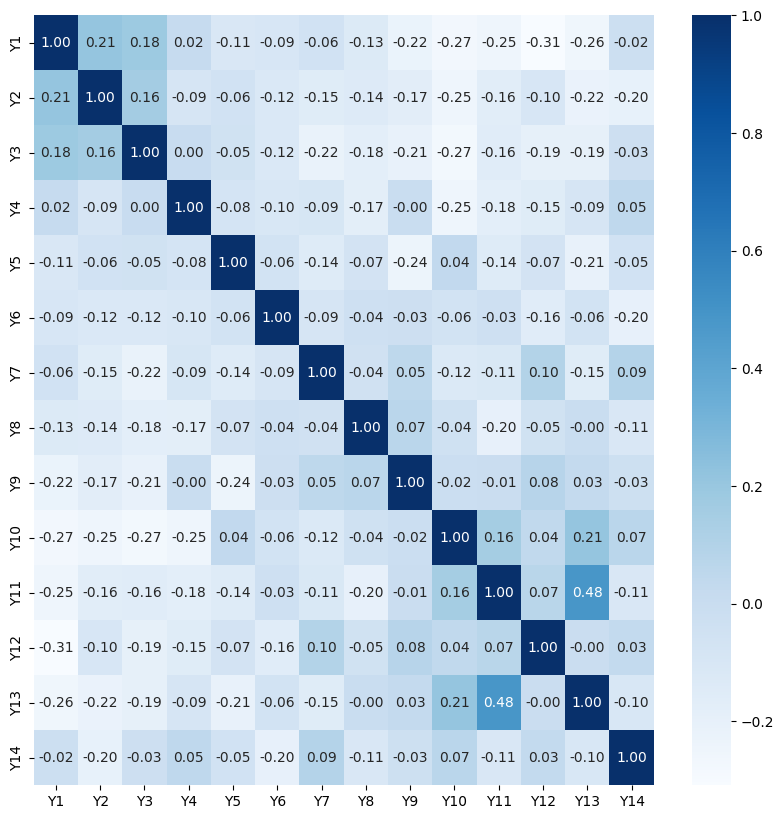

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')

In [ ]:
# cek data duplikat

df.duplicated().sum()

2

Ternyata terdapat 2 data yang duplikat, bisa kita hapus salah satunya saja

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
df.duplicated().sum()

0

Sudah tidak ada yang duplikat

##Mulai tahapan membuat model ML

###1. Mengubah tipe data string ke dalam label numeric agar lebih mudah dipahami ML

In [ ]:
for col in cats:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,jenis_kelamin,umur,pekerjaan,hobi,tujuan_berwisata,status_perkawinan,daerah_asal,teman_perjalanan,pendidikan_terakhir,repetition,...,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12,Y13,Y14
0,0,0,2,3,3,0,1,1,2,1,...,1,0,0,0,0,0,0,0,0,0
1,1,0,3,4,3,0,1,4,2,0,...,1,0,0,1,0,0,0,0,0,0
2,1,0,2,4,3,0,1,0,2,1,...,1,1,0,1,0,0,0,1,0,0
3,1,0,2,4,3,0,1,4,2,0,...,1,1,0,1,0,1,0,0,0,0
4,0,0,2,3,3,0,1,4,2,1,...,0,1,1,1,0,0,0,0,0,0


###2. Memisahkan antara fitur dan target

In [ ]:
X = df[cats]
y = df[nums]

###3. Memisahkan data training dan testing set (sebesar 80% training, 20% testing)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###4. Scaling fitur umur menjadi numeric

In [ ]:
num_cols = ['umur']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
num_categories = [len(df[col].unique()) for col in cats]

###5. Model algoritma NCF

In [ ]:
def create_ncf_model(num_categories, latent_dim, hidden_dim):
    input_layers = []
    embedding_layers = []

    for num in num_categories:
        input_layer = Input(shape=(1,))
        embedding_layer = Embedding(num, latent_dim)(input_layer)
        flatten_layer = Flatten()(embedding_layer)
        input_layers.append(input_layer)
        embedding_layers.append(flatten_layer)

    repetition_input = Input(shape=(1,))
    repetition_embedding = Embedding(num_categories[-1], latent_dim)(repetition_input)
    repetition_flatten = Flatten()(repetition_embedding)
    embedding_layers.append(repetition_flatten)

    concat = Concatenate()(embedding_layers)
    x = Dense(hidden_dim, activation='relu')(concat)
    x = Dropout(0.2)(x)
    x = Dense(hidden_dim, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(14, activation='sigmoid')(x)

    model = Model(inputs=input_layers + [repetition_input], outputs=output)
    return model

###6. Membuat model

In [ ]:
latent_dim = 20
hidden_dim = 50

model = create_ncf_model(num_categories, latent_dim, hidden_dim)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

###7. Mulai training model

In [ ]:
history = model.fit([X_train[col] for col in cats] + [X_train['repetition']],
                    y_train, batch_size=64, epochs=50,
                    validation_data=([X_test[col] for col in cats] + [X_test['repetition']], y_test),
                    verbose=1)

Epoch 1/50
3/3 [==============================] - 2s 178ms/step - loss: 0.6917 - accuracy: 0.0111 - val_loss: 0.6865 - val_accuracy: 0.0222
Epoch 2/50
3/3 [==============================] - 0s 33ms/step - loss: 0.6836 - accuracy: 0.0444 - val_loss: 0.6794 - val_accuracy: 0.0222
Epoch 3/50
3/3 [==============================] - 0s 32ms/step - loss: 0.6755 - accuracy: 0.0278 - val_loss: 0.6714 - val_accuracy: 0.0444
Epoch 4/50
3/3 [==============================] - 0s 24ms/step - loss: 0.6658 - accuracy: 0.0500 - val_loss: 0.6623 - val_accuracy: 0.0444
Epoch 5/50
3/3 [==============================] - 0s 23ms/step - loss: 0.6561 - accuracy: 0.0722 - val_loss: 0.6524 - val_accuracy: 0.0444
Epoch 6/50
3/3 [==============================] - 0s 23ms/step - loss: 0.6442 - accuracy: 0.0500 - val_loss: 0.6420 - val_accuracy: 0.0444
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.6317 - accuracy: 0.0944 - val_loss: 0.6312 - val_accuracy: 0.0444
Epoch 8/50
3/3 [==========

In [ ]:
loss, accuracy = model.evaluate([X_test[col] for col in cats] + [X_test['repetition']], y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

2/2 [==============================] - 0s 9ms/step - loss: 0.6025 - accuracy: 0.4444
Accuracy: 44.44%


####Compile model dengan metric MAE dan RMSE

In [ ]:
model.compile(
    loss = 'mean_squared_error',
    optimizer = Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit([X_train[col] for col in cats] + [X_train['repetition']],
                    y_train, batch_size=64, epochs=50,
                    validation_data=([X_test[col] for col in cats] + [X_test['repetition']], y_test),
                    verbose=1)

Epoch 1/50
3/3 [==============================] - 3s 197ms/step - loss: 0.1862 - mean_absolute_error: 0.3757 - root_mean_squared_error: 0.4316 - val_loss: 0.2062 - val_mean_absolute_error: 0.3877 - val_root_mean_squared_error: 0.4541
Epoch 2/50
3/3 [==============================] - 0s 26ms/step - loss: 0.1875 - mean_absolute_error: 0.3763 - root_mean_squared_error: 0.4330 - val_loss: 0.2071 - val_mean_absolute_error: 0.3857 - val_root_mean_squared_error: 0.4550
Epoch 3/50
3/3 [==============================] - 0s 33ms/step - loss: 0.1864 - mean_absolute_error: 0.3746 - root_mean_squared_error: 0.4318 - val_loss: 0.2071 - val_mean_absolute_error: 0.3856 - val_root_mean_squared_error: 0.4551
Epoch 4/50
3/3 [==============================] - 0s 34ms/step - loss: 0.1866 - mean_absolute_error: 0.3744 - root_mean_squared_error: 0.4320 - val_loss: 0.2074 - val_mean_absolute_error: 0.3853 - val_root_mean_squared_error: 0.4554
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - lo

In [ ]:
loss, mae, rmse = model.evaluate([X_test[col] for col in cats] + [X_test['repetition']], y_test)

print(f'\nMAE: {mae}\n RMSE: {rmse}')

2/2 [==============================] - 0s 13ms/step - loss: 0.2086 - mean_absolute_error: 0.3803 - root_mean_squared_error: 0.4567

MAE: 0.3803021013736725
 RMSE: 0.45674407482147217


#####Apakah data row yang hanya berisi 255 data mungkin bisa membuat performa tidak meningkat?

Ya, ukuran dataset yang kecil bisa menjadi faktor yang mempengaruhi performa model, terutama jika model memiliki banyak parameter (seperti pada Neural Collaborative Filtering dengan banyak node embedding, hidden layers, dll.) atau jika dataset memiliki kompleksitas yang tinggi.

Berikut adalah beberapa alasan mengapa ukuran dataset yang kecil dapat mempengaruhi performa model:

1. Kurangnya Informasi:
Dengan jumlah data yang terbatas, model mungkin kesulitan untuk menemukan pola yang signifikan atau mewakili kecenderungan yang ada di dalam dataset.